In [69]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

In [70]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [71]:
img_height, img_width = 256, 256
batch_size = 8

In [72]:

# train_ds = tf.keras.preprocessing.image_dataset_from_directory('data/dataset/pushing',
train_ds = tf.keras.preprocessing.image_dataset_from_directory('data/dataset/push',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 171 files belonging to 2 classes.


In [73]:
train_ds

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>

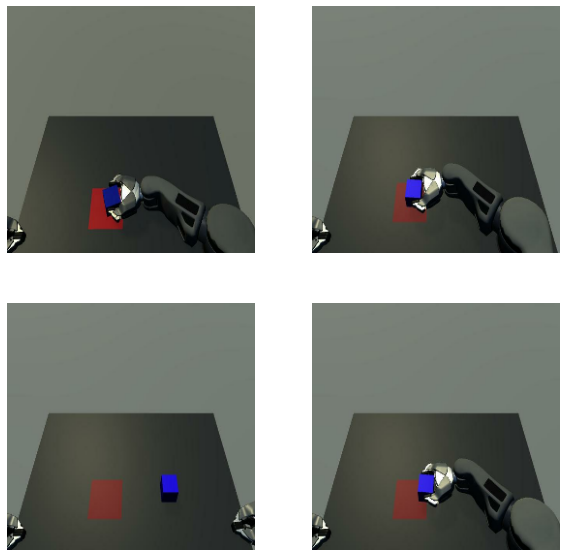

In [74]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [75]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [3]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

NameError: name 'train_ds' is not defined

In [77]:
print(np.min(first_image), np.max(first_image)) 


0.0 1.0


In [78]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [79]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

In [80]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
  
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
 

    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [81]:
enc = encoder(input_encoder)

In [82]:
# enc.save('vae-enc.h5')

In [83]:
# enc.summary()

In [84]:
input_1 = (200,)
input_2 = (200,)

In [85]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [86]:
final = sampling(input_1,input_2)

In [87]:
# final.save('sampling.h5')

In [88]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

  
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [89]:
dec = decoder(input_decoder)

In [90]:
# dec.save('vae-dec.h5')

In [91]:
# dec.summary()

In [92]:
#model.layers[1].get_weights()

In [93]:
#model.save('autoencoder.h5')

In [94]:
optimizer = tf.keras.optimizers.Adam(lr = 0.05) #0.0005

In [95]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss


def kl_loss(mean, log_var):
    loss_kl =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return loss_kl
    
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    loss_kl = kl_loss(mean, log_var)
    return  r_loss + loss_kl


In [96]:
os.makedirs('vae/training_weights', exist_ok=True)
os.makedirs('vae/images', exist_ok=True)

In [97]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [101]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            # checkpoint.save(file_prefix = checkpoint_prefix)
            enc.save_weights('vae/training_weights/enc_'+ str(epoch)+'.h5')
            dec.save_weights('vae/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [102]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('vae/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(3, 256, 256, 3)


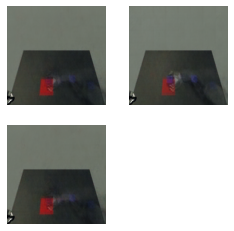

In [103]:
train(normalized_ds, 100)

In [104]:
# enc.load_weights('vae/training_weights/enc_19.h5') 

In [105]:
# dec.load_weights('/vae/training_weights/dec_19.h5')

In [106]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > 5000:
        break

In [107]:
embeddings.shape

(171, 200)

## Latent Space Projection with t-SNE of VAE Trained on data Set

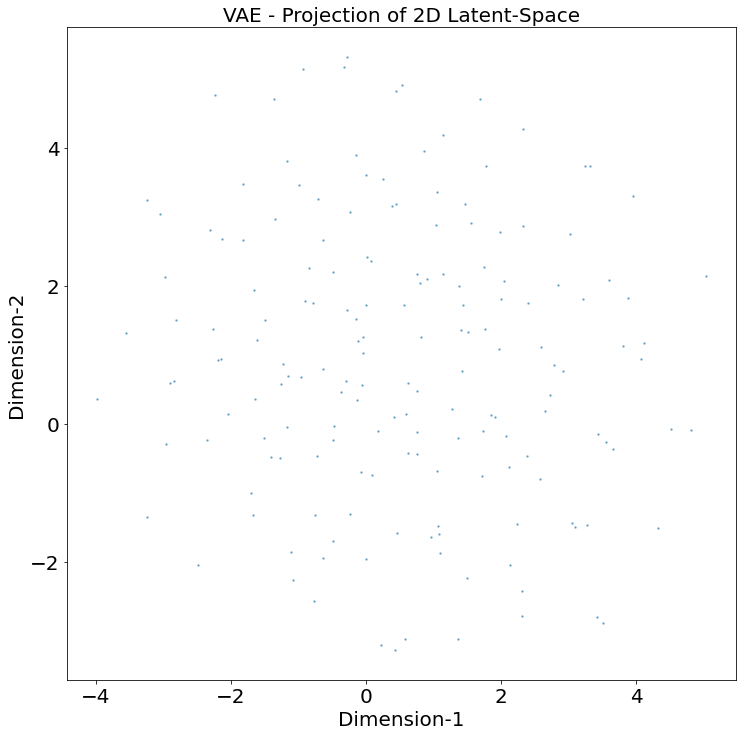

In [108]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("VAE - Projection of 2D Latent-Space", size=20)
plt.show()

In [2]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

NameError: name 'normalized_ds' is not defined

In [1]:
figsize = 15


min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

NameError: name 'lat_space' is not defined

In [237]:
reconstruction.shape

(258, 256, 256, 3)

## Reconstructing Test Images

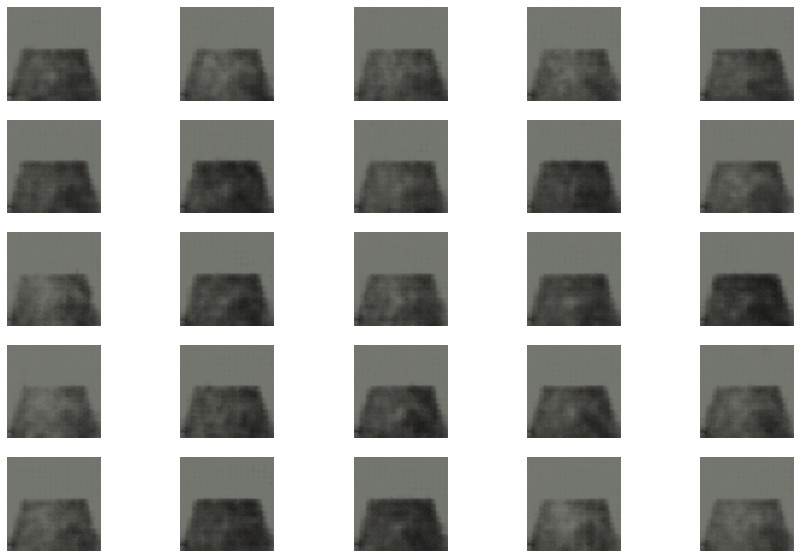

In [238]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

## Reconstructing Images from a Latent-Vector Sampled with Normal Distribution

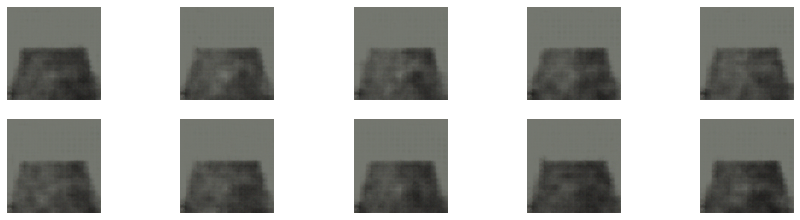

In [239]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Images with Latent-Vector Sampled Uniformly